In [1]:
import pandas as pd
import requests
import os
from threading import Thread
from  torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary
import torch
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image
from pathlib import Path

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
df = pd.read_csv("../data/US_youtube_trending_data.csv")
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


In [34]:
likes_mean = df['likes'].mean()
df["likes"] = df["likes"].replace(0,likes_mean)

In [35]:
view_count_mean = df['view_count'].mean()
df["view_count"] = df["view_count"].replace(0,view_count_mean)

In [36]:
df.drop_duplicates(subset=['thumbnail_link', 'video_id'], keep='last', inplace=True)
df.shape[0]

44009

In [37]:
def categorize_image(row):
    likes_to_view_percent = row['likes'] * 100 / row['view_count']
    if likes_to_view_percent < 2:
        return 'unpopular'
    
    if likes_to_view_percent >= 2 and likes_to_view_percent < 5:
        return 'semi-popular'
    
    if likes_to_view_percent >= 5 and likes_to_view_percent < 10:
        return 'popular'
    
    if likes_to_view_percent >= 10:
        return 'very-popular'

In [38]:
df['image_category'] = df.apply(categorize_image, axis=1)
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,image_category
172,cAtazIk1IYw,How To Make a Curried Egg Sandwich,2020-08-07T18:30:06Z,UCR4s1DE9J4DHzZYXMltSMAg,HowToBasic,26,2020-08-12T00:00:00Z,how to make a curried egg sandwich|curried egg...,1238677.0,104736.0,3736,13876,https://i.ytimg.com/vi/cAtazIk1IYw/default.jpg,False,False,Today I show you how to make a curried egg san...,popular
173,NYFHnIiA8gE,Cake Rescue Fixing Viral Cake Fails | How To C...,2020-08-07T09:30:04Z,UCsP7Bpw36J666Fct5M8u-ZA,How To Cook That,24,2020-08-12T00:00:00Z,cake rescue|caek fail|viral cake fails|funny c...,938198.0,44088.0,565,2409,https://i.ytimg.com/vi/NYFHnIiA8gE/default.jpg,False,False,"Cake Rescue: viral cake fails, how to rescue ...",semi-popular
174,czwejgoH3zs,"Son, lemme teach you something new",2020-08-06T19:47:12Z,UCw03U5DZGLqvv5elJvXvR0Q,Bread Boys,24,2020-08-12T00:00:00Z,[None],1722152.0,169501.0,927,7263,https://i.ytimg.com/vi/czwejgoH3zs/default.jpg,False,False,badum tss *funny haha noises*YOU CAN FIND US H...,popular
175,dO6YihaqtaQ,Trump takes executive action to address econom...,2020-08-09T01:35:42Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,25,2020-08-12T00:00:00Z,president|trump|donald|executive|orders|stimul...,1090847.0,10922.0,2517,9876,https://i.ytimg.com/vi/dO6YihaqtaQ/default.jpg,False,False,The president’s order includes unemployment re...,unpopular
176,sSjtGqRXQ9Y,JUDAS AND THE BLACK MESSIAH - Official Trailer,2020-08-06T23:01:42Z,UCjmJDM5pRKbUlVIzDYYWb6g,Warner Bros. Pictures,24,2020-08-12T00:00:00Z,warner bros|warner brothers|wb|fred hampton|wi...,971704.0,23311.0,1987,3240,https://i.ytimg.com/vi/sSjtGqRXQ9Y/default.jpg,False,False,Watch the trailer for Judas and the Black Mess...,semi-popular


In [39]:
print('unpopular: ' + str(df[df['image_category'] == 'unpopular'].shape[0]))
print('semi-popular: ' + str(df[df['image_category'] == 'semi-popular'].shape[0]))
print('popular: ' + str(df[df['image_category'] == 'popular'].shape[0]))
print('very-popular: ' + str(df[df['image_category'] == 'very-popular'].shape[0]))

unpopular: 9102
semi-popular: 17006
popular: 14712
very-popular: 3189


In [40]:
columns_to_delete = ['title', 'channelId', 'channelTitle', 'tags', 'comments_disabled', 'ratings_disabled', 'description', 'publishedAt', 'trending_date', 'categoryId', 'view_count', 'likes', 'dislikes', 'comment_count']

for column in columns_to_delete : 
    df.drop(column, axis='columns', inplace=True)
    
df.head()

,video_id,thumbnail_link,image_category
172,cAtazIk1IYw,https://i.ytimg.com/vi/cAtazIk1IYw/default.jpg,popular
173,NYFHnIiA8gE,https://i.ytimg.com/vi/NYFHnIiA8gE/default.jpg,semi-popular
174,czwejgoH3zs,https://i.ytimg.com/vi/czwejgoH3zs/default.jpg,popular
175,dO6YihaqtaQ,https://i.ytimg.com/vi/dO6YihaqtaQ/default.jpg,unpopular
176,sSjtGqRXQ9Y,https://i.ytimg.com/vi/sSjtGqRXQ9Y/default.jpg,semi-popular


In [41]:
if not os.path.exists('../data/images'):
    os.mkdir('../data/images')
    os.mkdir('../data/images/train')
    os.mkdir('../data/images/test')
    os.mkdir('../data/images/train/unpopular')
    os.mkdir('../data/images/train/semi-popular')
    os.mkdir('../data/images/train/popular')
    os.mkdir('../data/images/train/very-popular')
    os.mkdir('../data/images/test/unpopular')
    os.mkdir('../data/images/test/semi-popular')
    os.mkdir('../data/images/test/popular')
    os.mkdir('../data/images/test/very-popular')
    
    default_image_link = str(df[df['video_id'] == '_4_mAt4nexs'].iloc[0]['thumbnail_link'])
    data = requests.get(default_image_link).content
    with open('../data/images/default.jpg', 'wb') as f:
        f.write(data)

In [2]:
f = open('../data/images/default.jpg','rb')
default_image = f.read()
f.close()

In [43]:
def download_images(df, number, default_image):
    i = 0
    
    for index, row in df.iterrows():
        type = 'test' if i % 5 == 0 else 'train'
        
        data = requests.get(row['thumbnail_link']).content
        if data == default_image:
            continue
        
        image_path = '../data/images/{type}/{category}/{video_id}.jpg'.format(type=type, category=row['image_category'], video_id=row['video_id'])
        with open(image_path, 'wb') as f:
            f.write(data)

        i+=1
    
    print("Downloader " + str(number) + " completed " + str(i) + "/" + str(df.shape[0]))

In [44]:
DF_SPLIT = 10000
threads = []
df_length = int(df.shape[0] / DF_SPLIT)

for i in range(df_length):
    start = i*DF_SPLIT
    end = df.shape[0] if i == df_length - 1 else (i+1)*DF_SPLIT

    df_split = df.iloc[start:end, :]
    threads.append(Thread(target=download_images, args=(df_split, i+1, default_image)))

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

Downloader 3 completed 9737/10000
Downloader 2 completed 9633/10000
Downloader 1 completed 9529/10000
Downloader 4 completed 13830/14009


#### Images per class before augmentation

In [49]:
for dirpath, dirnames, filenames in os.walk('../data/images/'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in '../data/images/'.
There are 4 directories and 0 images in '../data/images/test'.
There are 0 directories and 2903 images in '../data/images/test\popular'.
There are 0 directories and 3343 images in '../data/images/test\semi-popular'.
There are 0 directories and 1705 images in '../data/images/test\unpopular'.
There are 0 directories and 596 images in '../data/images/test\very-popular'.
There are 4 directories and 0 images in '../data/images/train'.
There are 0 directories and 11489 images in '../data/images/train\popular'.
There are 0 directories and 13252 images in '../data/images/train\semi-popular'.
There are 0 directories and 6952 images in '../data/images/train\unpopular'.
There are 0 directories and 2489 images in '../data/images/train\very-popular'.


In [2]:
def augment_image(img_path, rotate, jitter, flip):
    original_image = Image.open(Path(img_path))
    
    random_rotation_transformation_45_image = transforms.RandomRotation(45)(original_image) if rotate else None
    colour_jitter_image = transforms.ColorJitter(brightness=(0.5,1.5),contrast=(3),saturation=(0.3,1.5),hue=(-0.1,0.1))(original_image) if jitter else None
    flipped_image = transforms.RandomVerticalFlip(p=1)(original_image) if flip else None

    return [random_rotation_transformation_45_image,colour_jitter_image,flipped_image], ['rotated', 'jittered', 'flipped']

In [3]:
def augment_image_class(image_class_path, rotate = True, jitter = True, flip = True):
    
    images_in_folder = os.listdir(image_class_path)
    
    for image in images_in_folder:
        image_path = "{folder_path}/{image_name}".format(folder_path=image_class_path, image_name=image)
        augmented_images, augmentations = augment_image(image_path, rotate, jitter, flip)

        for i in range(len(augmented_images)):
            if not augmented_images[i]:
                continue

            new_image_name = augmentations[i] + '_' + image
            augmented_images[i].save("{folder_path}/{augmented_image_name}".format(folder_path=image_class_path, augmented_image_name=new_image_name))

In [4]:
augment_image_class('../data/images/test/unpopular/', rotate=False, jitter=False)
augment_image_class('../data/images/test/very-popular/')
augment_image_class('../data/images/train/unpopular/', rotate=False, jitter=False)
augment_image_class('../data/images/train/very-popular/')

#### Images per class after augmentation

In [5]:
for dirpath, dirnames, filenames in os.walk('../data/images/'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in '../data/images/'.
There are 4 directories and 0 images in '../data/images/test'.
There are 0 directories and 2903 images in '../data/images/test\popular'.
There are 0 directories and 3343 images in '../data/images/test\semi-popular'.
There are 0 directories and 3410 images in '../data/images/test\unpopular'.
There are 0 directories and 2384 images in '../data/images/test\very-popular'.
There are 4 directories and 0 images in '../data/images/train'.
There are 0 directories and 11489 images in '../data/images/train\popular'.
There are 0 directories and 13252 images in '../data/images/train\semi-popular'.
There are 0 directories and 13904 images in '../data/images/train\unpopular'.
There are 0 directories and 9956 images in '../data/images/train\very-popular'.


In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [2]:
transforms = transforms.Compose([
    ResNet50_Weights.IMAGENET1K_V2.transforms(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(45),
    transforms.GaussianBlur(kernel_size = (7,13), sigma = (1 , 4))
]) 
transforms

Compose(
    ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
    RandomVerticalFlip(p=0.2)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    GaussianBlur(kernel_size=(7, 13), sigma=(1, 4))
)

In [3]:
train_dataset = datasets.ImageFolder('../data/images/train', transform=transforms)
len(train_dataset)

48601

In [4]:
test_dataset = datasets.ImageFolder('../data/images/test', transform=transforms)
len(test_dataset)

12040

In [6]:
def display_random_images(dataset,
                          classes,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    if n > 10:
        n = 10
        display_shape = False
    
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


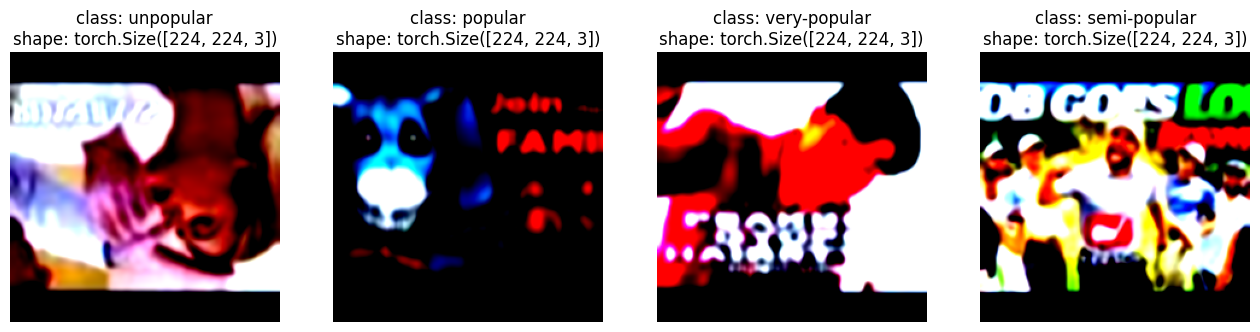

In [7]:
display_random_images(train_dataset, 
                      n=4, 
                      classes=train_dataset.classes,
                      seed=None)

In [5]:
num_workers = os.cpu_count()
batch_size = 32

train_dataloader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
)

test_dataloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [24]:
i = 0
for param in model.parameters():
    if i >= 129:
        continue
    param.requires_grad = False
    i+=1

In [25]:
model.fc = nn.Linear(in_features=2048, out_features=len(train_dataset.classes), bias=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [27]:
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.8105, 0.7815, 0.7707, 0.8358]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
def train_step(model: torch.nn.Module, 
               dataloader: DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.train()
  train_loss, train_acc, train_precision, train_recall, train_f1 = 0, 0, 0, 0, 0
  true_positives = [0, 0, 0, 0]
  false_positives = [0, 0, 0, 0]
  false_negatives = [0, 0, 0, 0]

  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
      for i in range(len(y_pred_class)):
            if(y_pred_class[i] == y[i]):
                true_positives[int(y_pred_class[i])] += 1
            else:
                false_positives[int(y_pred_class[i])] += 1
                false_negatives[int(y[i])] += 1

  dataloader_length = len(dataloader)
  for i in range(len(true_positives)):
        train_precision += true_positives[i] / (true_positives[i] + false_positives[i])
        train_recall += true_positives[i] / (true_positives[i] + false_negatives[i])

  train_loss = train_loss / dataloader_length
  train_acc = train_acc / dataloader_length
  train_precision = train_precision / len(true_positives)
  train_recall = train_recall / len(true_positives)
  train_f1 = 2 * train_precision * train_recall / (train_precision + train_recall)
  return train_loss, train_acc, train_precision, train_recall, train_f1

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
  model.eval() 

  test_loss, test_acc, test_precision, test_recall, test_f1 = 0, 0, 0, 0, 0
  true_positives = [0, 0, 0, 0]
  false_positives = [0, 0, 0, 0]
  false_negatives = [0, 0, 0, 0]

  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          test_pred_logits = model(X)
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
          for i in range(len(test_pred_labels)):
                if(test_pred_labels[i] == y[i]):
                    true_positives[int(test_pred_labels[i])] += 1
                else:
                    false_positives[int(test_pred_labels[i])] += 1
                    false_negatives[int(y[i])] += 1

  dataloader_length = len(dataloader)
  for i in range(len(true_positives)):
    test_precision += true_positives[i] / (true_positives[i] + false_positives[i])
    test_recall += true_positives[i] / (true_positives[i] + false_negatives[i])

  test_loss = test_loss / dataloader_length
  test_acc = test_acc / dataloader_length
  test_precision = test_precision / len(true_positives)
  test_recall = test_recall / len(true_positives)
  test_f1 = 2 * test_precision * test_recall / (test_precision + test_recall)
  return test_loss, test_acc, test_precision, test_recall, test_f1

def train(model: torch.nn.Module, 
          train_dataloader: DataLoader, 
          test_dataloader: DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
  results = {"train_loss": [],
      "train_acc": [],
      "train_precision": [],
      "train_recall": [],
      "train_f1": [],
      "test_loss": [],
      "test_acc": [],
      "test_precision": [],
      "test_recall": [],
      "test_f1": []
  }

  for epoch in tqdm(range(epochs)):
      train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(model=model,
                                                                                  dataloader=train_dataloader,
                                                                                  loss_fn=loss_fn,
                                                                                  optimizer=optimizer,
                                                                                  device=device)
      test_loss, test_acc, test_precision, test_recall, test_f1 = test_step(model=model,
                                                                            dataloader=test_dataloader,
                                                                            loss_fn=loss_fn,
                                                                            device=device)

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"train_precision: {train_precision:.4f} | "
          f"train_recall: {train_recall:.4f} | "
          f"train_f1: {train_f1:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"test_precision: {test_precision:.4f} | "
          f"test_recall: {test_recall:.4f} | "
          f"test_f1: {test_f1:.4f}"
      )

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["train_precision"].append(train_precision)
      results["train_recall"].append(train_recall)
      results["train_f1"].append(train_f1)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["test_precision"].append(test_precision)
      results["test_recall"].append(test_recall)
      results["test_f1"].append(test_f1)

  return results

In [29]:
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

  5%|▌         | 1/20 [05:26<1:43:27, 326.73s/it]

Epoch: 1 | train_loss: 1.0922 | train_acc: 0.5010 | train_precision: 0.4982 | train_recall: 0.4995 | train_f1: 0.4989 | test_loss: 1.0525 | test_acc: 0.5293 | test_precision: 0.5557 | test_recall: 0.5225 | test_f1: 0.5386


 10%|█         | 2/20 [10:52<1:37:55, 326.43s/it]

Epoch: 2 | train_loss: 1.0037 | train_acc: 0.5483 | train_precision: 0.5497 | train_recall: 0.5476 | train_f1: 0.5486 | test_loss: 1.0039 | test_acc: 0.5492 | test_precision: 0.5485 | test_recall: 0.5565 | test_f1: 0.5525


 15%|█▌        | 3/20 [16:17<1:32:15, 325.61s/it]

Epoch: 3 | train_loss: 0.9600 | train_acc: 0.5692 | train_precision: 0.5723 | train_recall: 0.5684 | train_f1: 0.5703 | test_loss: 1.0245 | test_acc: 0.5403 | test_precision: 0.5380 | test_recall: 0.5387 | test_f1: 0.5383


 20%|██        | 4/20 [21:42<1:26:42, 325.18s/it]

Epoch: 4 | train_loss: 0.9327 | train_acc: 0.5833 | train_precision: 0.5863 | train_recall: 0.5834 | train_f1: 0.5848 | test_loss: 0.9882 | test_acc: 0.5587 | test_precision: 0.5857 | test_recall: 0.5667 | test_f1: 0.5760


 25%|██▌       | 5/20 [27:08<1:21:22, 325.48s/it]

Epoch: 5 | train_loss: 0.9020 | train_acc: 0.5979 | train_precision: 0.6019 | train_recall: 0.5982 | train_f1: 0.6000 | test_loss: 1.0188 | test_acc: 0.5521 | test_precision: 0.5677 | test_recall: 0.5630 | test_f1: 0.5654


 30%|███       | 6/20 [32:40<1:16:29, 327.79s/it]

Epoch: 6 | train_loss: 0.8758 | train_acc: 0.6102 | train_precision: 0.6137 | train_recall: 0.6107 | train_f1: 0.6122 | test_loss: 1.0116 | test_acc: 0.5630 | test_precision: 0.5663 | test_recall: 0.5678 | test_f1: 0.5670


 35%|███▌      | 7/20 [38:24<1:12:10, 333.15s/it]

Epoch: 7 | train_loss: 0.8479 | train_acc: 0.6206 | train_precision: 0.6237 | train_recall: 0.6216 | train_f1: 0.6226 | test_loss: 0.9964 | test_acc: 0.5685 | test_precision: 0.5723 | test_recall: 0.5721 | test_f1: 0.5722


 40%|████      | 8/20 [43:50<1:06:11, 330.99s/it]

Epoch: 8 | train_loss: 0.8253 | train_acc: 0.6352 | train_precision: 0.6390 | train_recall: 0.6360 | train_f1: 0.6375 | test_loss: 1.0155 | test_acc: 0.5652 | test_precision: 0.5742 | test_recall: 0.5653 | test_f1: 0.5697


 45%|████▌     | 9/20 [49:14<1:00:16, 328.76s/it]

Epoch: 9 | train_loss: 0.8009 | train_acc: 0.6472 | train_precision: 0.6508 | train_recall: 0.6486 | train_f1: 0.6497 | test_loss: 1.0031 | test_acc: 0.5655 | test_precision: 0.5881 | test_recall: 0.5666 | test_f1: 0.5772


In [16]:
def plot_results(results):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    precision = results['train_precision']
    test_precision = results['test_precision']

    recall = results['train_recall']
    test_recall = results['test_recall']

    f1 = results['train_f1']
    test_f1 = results['test_f1']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=3, 
                        wspace=0.4, 
                        hspace=0.4)

    plt.subplot(5, 1, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(epochs, precision, label='train_precision')
    plt.plot(epochs, test_precision, label='test_precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(5, 1, 4)
    plt.plot(epochs, recall, label='train_recall')
    plt.plot(epochs, test_recall, label='test_recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(5, 1, 5)
    plt.plot(epochs, f1, label='train_f1')
    plt.plot(epochs, test_f1, label='test_f1')
    plt.title('F1')
    plt.xlabel('Epochs')
    plt.legend()

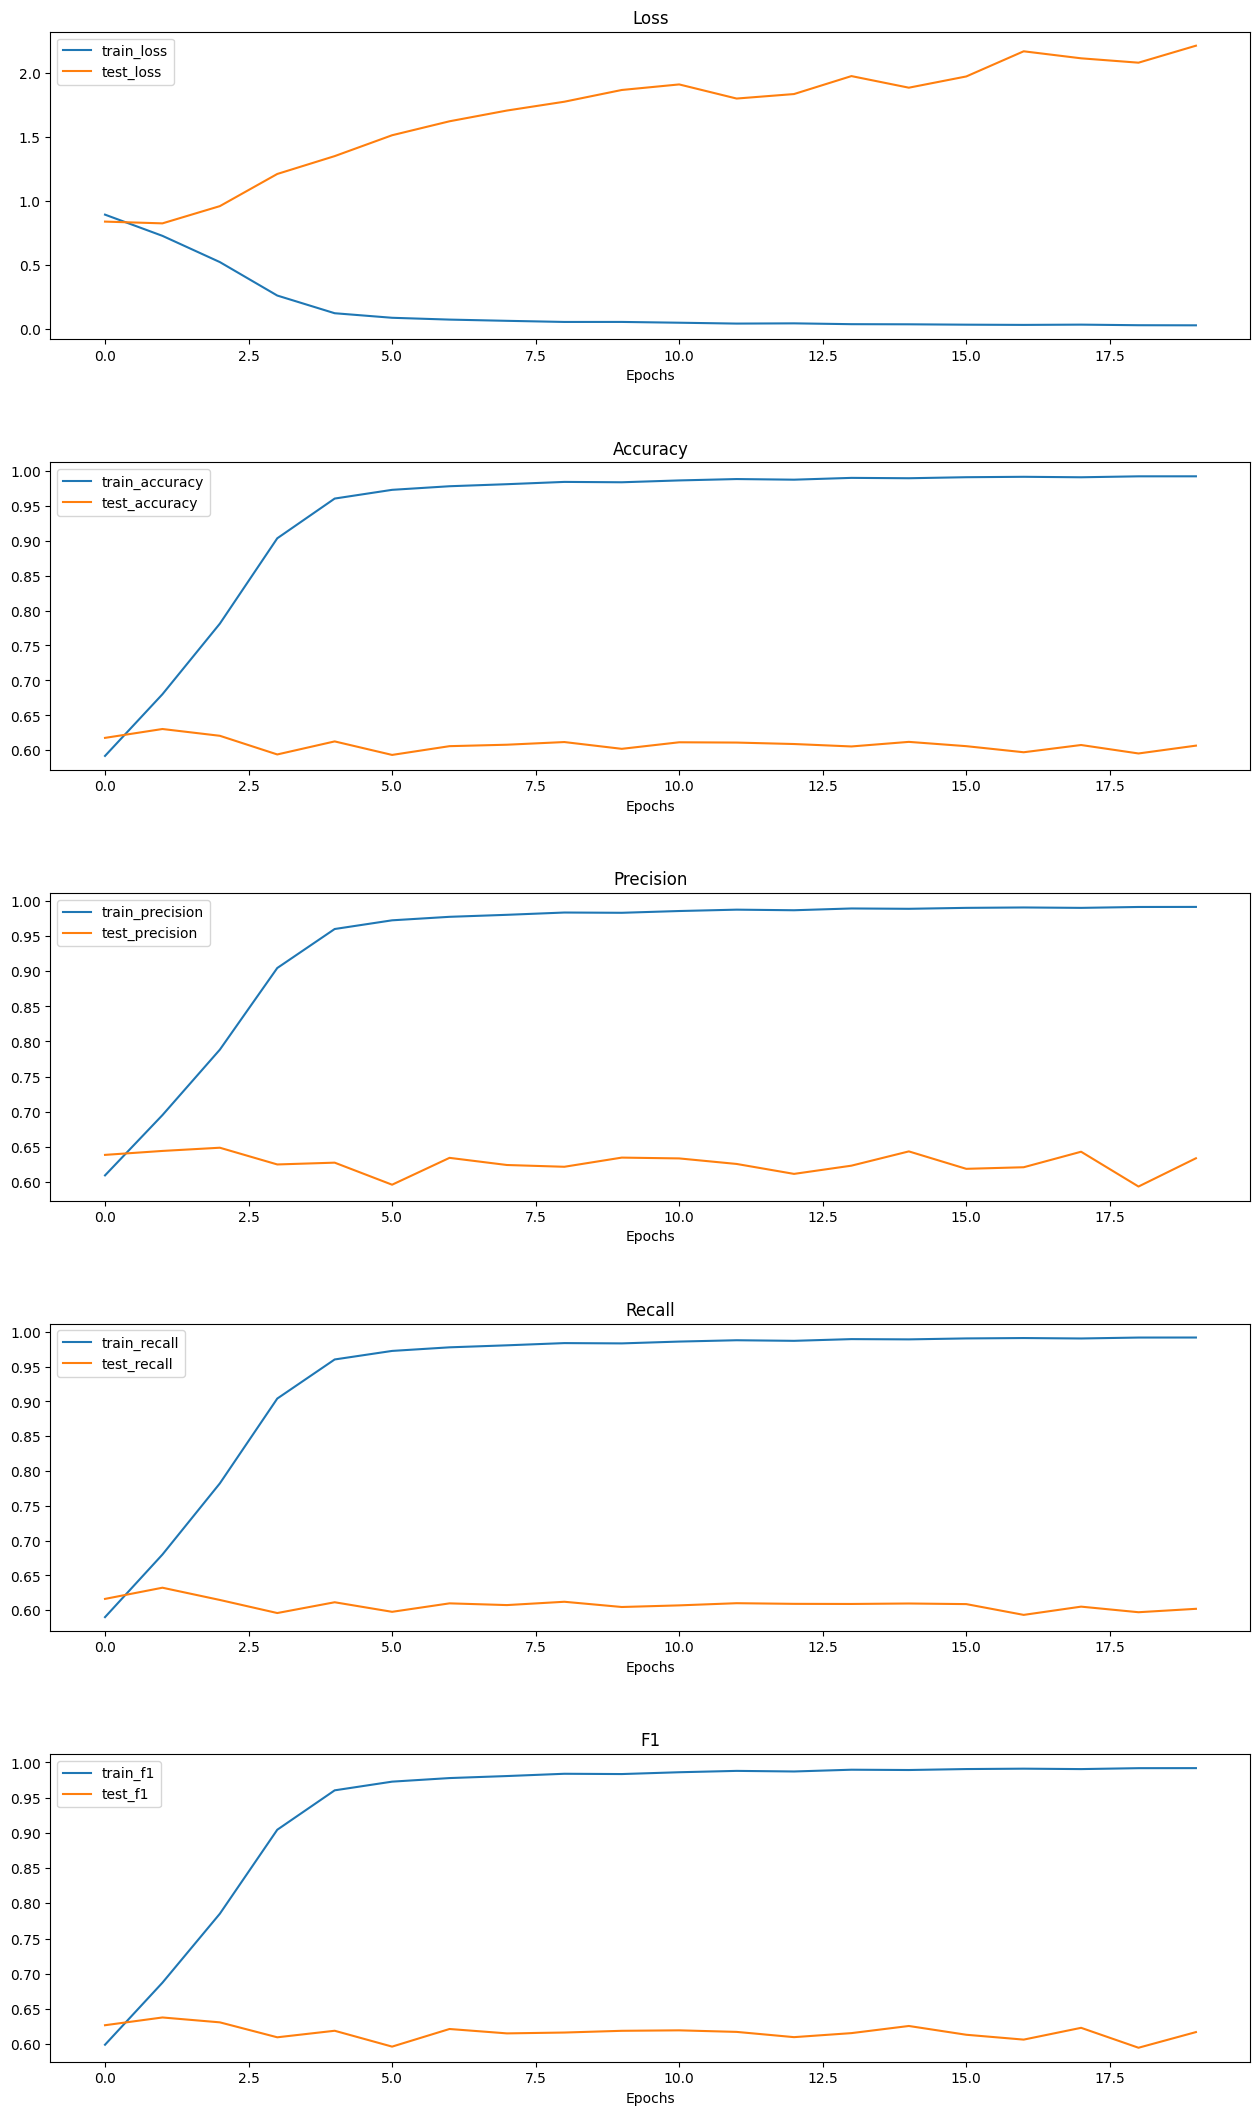

In [17]:
plot_results(results)

In [18]:
MODEL_PATH = Path("../models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [19]:
MODEL_NAME = "image_classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [20]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: ..\models\image_classifier.pth


In [21]:
loaded_model = resnet50().to(device)
loaded_model.fc = nn.Linear(in_features=2048, out_features=len(train_dataset.classes), bias=True)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names,
                        device: torch.device=device):
    
    img = Image.open(image_path)
    image_transform = ResNet50_Weights.IMAGENET1K_V2.transforms()
    model.to(device)
    model.eval()

    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    print(target_image_pred_probs)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    print(target_image_pred_label)
    print(class_names)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

tensor([[1.0000e+00, 1.9576e-09, 2.1992e-10, 3.0344e-07]], device='cuda:0')
tensor([0], device='cuda:0')
['popular', 'semi-popular', 'unpopular', 'very-popular']


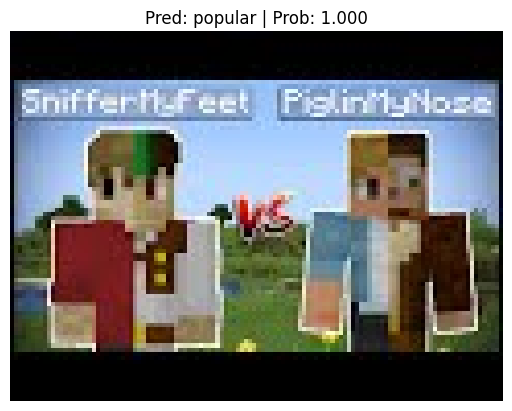

In [39]:
pred_and_plot_image(model=loaded_model, 
                    image_path="../data/images/train/popular/1WVRmKcjCOM.jpg",
                    class_names=train_dataset.classes)